In [1]:
import pybaseball
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az

In [2]:
#data = pybaseball.statcast('2018-06-01','2018-06-30')
data = pybaseball.statcast('2020-07-20','2020-09-30')

This is a large query, it may take a moment to complete
Completed sub-query from 2020-07-20 to 2020-07-25
Completed sub-query from 2020-07-26 to 2020-07-31
Completed sub-query from 2020-08-01 to 2020-08-06
Completed sub-query from 2020-08-07 to 2020-08-12
Completed sub-query from 2020-08-13 to 2020-08-18
Completed sub-query from 2020-08-19 to 2020-08-24
Completed sub-query from 2020-08-25 to 2020-08-30
Completed sub-query from 2020-08-31 to 2020-09-05
Completed sub-query from 2020-09-06 to 2020-09-11
Completed sub-query from 2020-09-12 to 2020-09-17
Completed sub-query from 2020-09-18 to 2020-09-23
Completed sub-query from 2020-09-24 to 2020-09-29
Completed sub-query from 2020-09-30 to 2020-09-30


In [3]:
df_bbe = data[data['type'] == "X"]
df_bbe.columns

Index(['index', 'pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
     

In [4]:
len(df_bbe)

44562

dependend variable: is_barrel (obtained from launch_speed_angle)

control variables (dummies): pitch_type (drop FF), zone (there is no 10), opp_stance (obtained from stand and p_throws), count (obtained from balls and strikes)

control variables (continuous): release_speed, release_pos_x (GET ABSOLUTE VALUE), release_pos_z, pfx_x, pfx_z, plate_x (abs), plate_z, vx0, vy0, vz0, ax, ay, az, sz_top, sz_bot, release_spin_rate, release_extension (release_pos_y is the opposite)

In [5]:
df_bbe = df_bbe.drop(['index','game_date','player_name','batter','pitcher','events','description','des','game_type','home_team','away_team','type','hit_location','bb_type','game_year','on_3b','on_2b','on_1b','outs_when_up','inning','inning_topbot','hc_x','hc_y','fielder_2','umpire','sv_id','hit_distance_sc','launch_speed','launch_angle','effective_speed','game_pk','pitcher.1','fielder_2.1','fielder_3',"fielder_4",'fielder_5','fielder_6','fielder_7','fielder_8','fielder_9','estimated_ba_using_speedangle','estimated_woba_using_speedangle','woba_value','woba_denom','babip_value','iso_value','at_bat_number','pitch_number','pitch_name','home_score','away_score','bat_score','fld_score','post_away_score','post_home_score','post_bat_score','post_fld_score','if_fielding_alignment','of_fielding_alignment','spin_dir','spin_rate_deprecated','break_angle_deprecated','break_length_deprecated','tfs_deprecated','tfs_zulu_deprecated'],axis=1)

In [6]:
df_bbe.columns

Index(['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone',
       'stand', 'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'release_spin_rate', 'release_extension', 'release_pos_y',
       'launch_speed_angle'],
      dtype='object')

<AxesSubplot:>

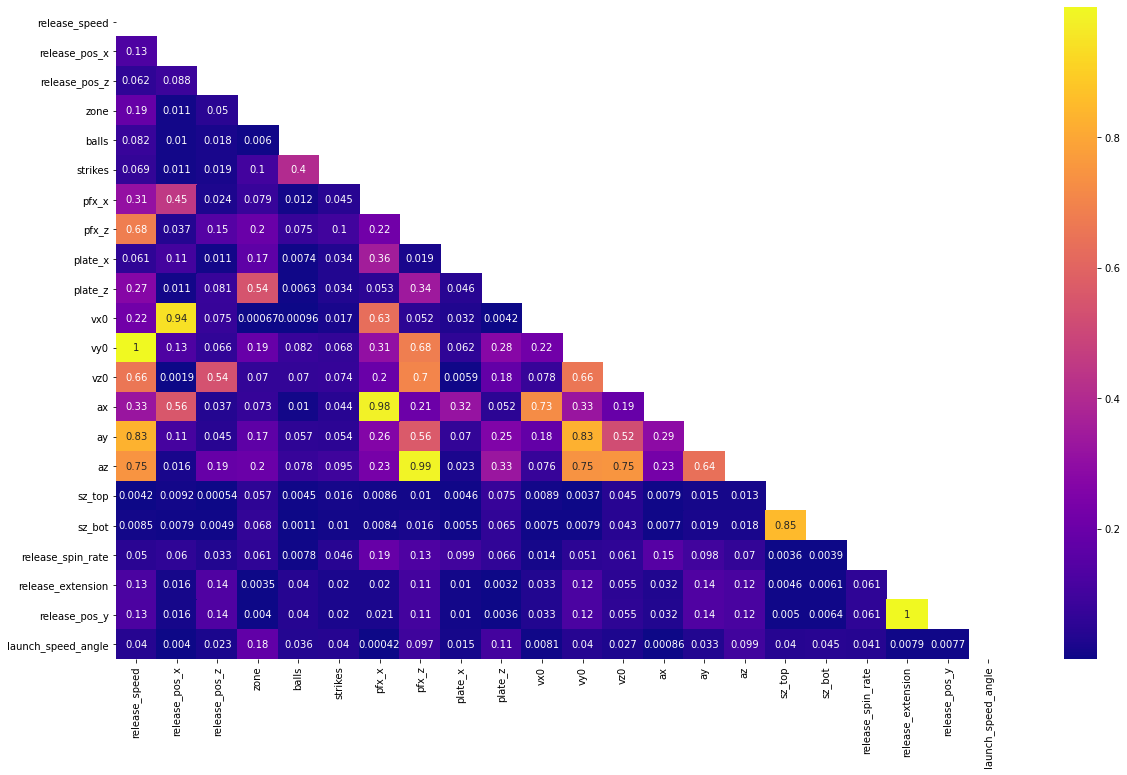

In [7]:
plt.figure(figsize=(20,12))
sns.heatmap(df_bbe.corr().abs(),mask=np.tri(*df_bbe.corr().shape).T ,annot=True,cmap='plasma')

dropped variables: release_speed (the same as vy0), release_extension (same as release_pos_y), pfx_x (close to ax), pfx_z (close to az)

In [8]:
df_bbe = df_bbe.drop(['release_speed','release_extension'],axis=1)
df_bbe.columns

Index(['pitch_type', 'release_pos_x', 'release_pos_z', 'zone', 'stand',
       'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'release_spin_rate', 'release_pos_y', 'launch_speed_angle'],
      dtype='object')

In [9]:
df_bbe['opp_stance'] = (df_bbe['stand'] != df_bbe['p_throws']).astype(int)

In [10]:
df_bbe['count_10'] = ((df_bbe['balls'] == 1) & (df_bbe['strikes'] == 0)).astype(int)
df_bbe['count_20'] = ((df_bbe['balls'] == 2) & (df_bbe['strikes'] == 0)).astype(int)
df_bbe['count_30'] = ((df_bbe['balls'] == 3) & (df_bbe['strikes'] == 0)).astype(int)
df_bbe['count_01'] = ((df_bbe['balls'] == 0) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_11'] = ((df_bbe['balls'] == 1) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_21'] = ((df_bbe['balls'] == 2) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_31'] = ((df_bbe['balls'] == 3) & (df_bbe['strikes'] == 1)).astype(int)
df_bbe['count_02'] = ((df_bbe['balls'] == 0) & (df_bbe['strikes'] == 2)).astype(int)
df_bbe['count_12'] = ((df_bbe['balls'] == 1) & (df_bbe['strikes'] == 2)).astype(int)
df_bbe['count_22'] = ((df_bbe['balls'] == 2) & (df_bbe['strikes'] == 2)).astype(int)
df_bbe['count_32'] = ((df_bbe['balls'] == 3) & (df_bbe['strikes'] == 2)).astype(int)

In [11]:
df_bbe[['release_pos_x','plate_x']]
df_bbe['release_pos_x_abs'] = df_bbe['release_pos_x'].apply(abs)
df_bbe['plate_x_abs'] = df_bbe['plate_x'].apply(abs)

In [12]:
df_bbe = df_bbe.join(pd.get_dummies(df_bbe['pitch_type']))

In [13]:
col_dict = {}
keys = np.arange(1,15,dtype=float)
values = []
for i in range(1,15): values.append('zone_'+str(i))
col_dict = dict(zip(keys,values))
df_bbe = df_bbe.join(pd.get_dummies(df_bbe['zone']).rename(columns=col_dict))

In [14]:
df_bbe['is_barrel'] = (df_bbe['launch_speed_angle'] == float(6)).astype(int)

In [15]:
df_bbe.columns

Index(['pitch_type', 'release_pos_x', 'release_pos_z', 'zone', 'stand',
       'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'release_spin_rate', 'release_pos_y', 'launch_speed_angle',
       'opp_stance', 'count_10', 'count_20', 'count_30', 'count_01',
       'count_11', 'count_21', 'count_31', 'count_02', 'count_12', 'count_22',
       'count_32', 'release_pos_x_abs', 'plate_x_abs', 'CH', 'CS', 'CU', 'FC',
       'FF', 'FO', 'FS', 'KC', 'KN', 'SI', 'SL', 'zone_1', 'zone_2', 'zone_3',
       'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11',
       'zone_12', 'zone_13', 'zone_14', 'is_barrel'],
      dtype='object')

Scaling some variables

In [16]:
df_bbe['release_spin_rate_sc'] = df_bbe['release_spin_rate']/1000
df_bbe['plate_x_sc'] = df_bbe['plate_x']*10
df_bbe['vy0_sc'] = df_bbe['vy0']/100
df_bbe['ay_sc'] = df_bbe['ay']/10
df_bbe['az_sc'] = df_bbe['az']/10
df_bbe['release_pos_y_sc'] = df_bbe['release_pos_y']/10

Variable groups

some variables: vx0, vy0, vz0, ax, ay, az, sz_top, sz_bot, release_pos_x_abs, release_pos_z, release_pos_y, plate_x_abs, plate_z, release_spin_rate, opp_stance

pfx_x and pfx_z (breakx and breakz) high corr. with ax and az

pitch type dummies or continuous variables?
most important cont. variables for pitch classification in order (Fonnesbeck): pfx_x, vy0, pfx_z (747), release_spin_rate (661), release_pos_z (426), release_pos_x (340), pitcher height, release_pos_y
https://github.com/fonnesbeck/baseball/blob/master/notebooks/Pitch%20Classification.ipynb

zone dummies or sz_top and sz_bot?

include count or not?

start with the 4 most important variables (Fonnesbeck): pfx_x, vy0, pfx_z, release_spin_rate

In [17]:
bbe_sample = df_bbe.sample(5000,random_state=123).round(3)
chain_n = 2
chain_len = 2000
burn_in = int(chain_len/2)
del data, df_bbe
bbe_sample.head()

,pitch_type,release_pos_x,release_pos_z,zone,stand,p_throws,balls,strikes,pfx_x,pfx_z,...,zone_12,zone_13,zone_14,is_barrel,release_spin_rate_sc,plate_x_sc,vy0_sc,ay_sc,az_sc,release_pos_y_sc
98061,CH,-0.36,6.47,14.0,R,R,0.0,2.0,-1.10,0.28,...,0,0,1,0,1.624,3.7,-1.198,2.285,-2.847,5.462
172314,SL,1.73,6.23,1.0,L,L,1.0,2.0,-0.50,0.62,...,0,0,0,0,2.150,-4.6,-1.190,2.411,-2.619,5.450
125059,CU,-2.63,5.48,6.0,R,R,0.0,1.0,0.17,0.08,...,0,0,0,0,2.327,3.3,-1.162,2.202,-3.168,5.468
234493,FF,-2.39,5.74,8.0,L,R,0.0,0.0,-0.87,1.16,...,0,0,0,0,2.239,-1.2,-1.327,2.543,-1.731,5.453
225806,SL,-2.11,6.18,8.0,L,R,2.0,1.0,0.07,0.11,...,0,0,0,0,2.453,-1.5,-1.160,1.860,-3.089,5.443


In [18]:
len(bbe_sample)

5000

In [19]:
with pm.Model() as model1:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace1 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 140 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [20]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.465,0.624,-4.615,-2.282,0.017,0.012,1334.0,1306.0,1349.0,1513.0,1.0
pfx_x,0.065,0.061,-0.048,0.176,0.001,0.001,2082.0,1950.0,2086.0,2312.0,1.0
pfx_z,0.285,0.093,0.114,0.464,0.002,0.002,1743.0,1691.0,1751.0,2092.0,1.0
vy0_sc,0.102,0.440,-0.677,1.112,0.012,0.010,1310.0,1052.0,1447.0,1371.0,1.0
release_spin_rate_sc,0.405,0.175,0.091,0.763,0.004,0.003,1687.0,1603.0,1708.0,1758.0,1.0
scale,0.477,0.399,0.037,1.148,0.010,0.007,1724.0,1724.0,1640.0,1587.0,1.0


Velocity and acceleration cont. variables vs pitch type dummies

In [21]:
with pm.Model() as model_2:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + release_spin_rate_sc + vx0 + vy0_sc + vz0 + ax + ay_sc + az_sc + release_pos_x + release_pos_z',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace2 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)
print(az.summary(trace2))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [release_pos_z, release_pos_x, az_sc, ay_sc, ax, vz0, vy0_sc, vx0, release_spin_rate_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 321 seconds.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -2.952  1.171  -5.121   -0.728      0.030    0.021   
pfx_x                 0.007  0.204  -0.407    0.399      0.004    0.004   
pfx_z                 0.030  0.221  -0.415    0.427      0.006    0.004   
release_spin_rate_sc  0.246  0.164  -0.029    0.553      0.003    0.002   
vx0                   0.035  0.034  -0.025    0.103      0.001    0.001   
vy0_sc               -0.035  0.292  -0.630    0.481      0.007    0.007   
vz0                   0.112  0.043   0.031    0.193      0.001    0.001   
ax                    0.014  0.020  -0.026    0.051      0.000    0.000   
ay_sc                 0.019  0.140  -0.258    0.286      0.003    0.003   
az_sc                 0.433  0.233   0.001    0.842      0.006    0.005   
release_pos_x         0.043  0.083  -0.108    0.205      0.002    0.002   
release_pos_z         0.207  0.136  -0.028    0.457      0.004    0.003   
scale                 0.1

In [22]:
# get rid of pitches KC FS EP KN SC
with pm.Model() as model_3:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + FF + CH + SL + FC + CU + SI + FS',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace3 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)
print(az.summary(trace3))

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [FS, SI, CU, FC, SL, CH, FF, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 147 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -2.779  0.555  -3.869   -1.760      0.019    0.013   
pfx_x                 0.061  0.062  -0.046    0.181      0.001    0.001   
pfx_z                 0.195  0.113  -0.000    0.420      0.003    0.002   
vy0_sc                0.095  0.346  -0.511    0.754      0.011    0.011   
release_spin_rate_sc  0.144  0.154  -0.122    0.442      0.004    0.003   
FF                    0.105  0.162  -0.175    0.447      0.005    0.003   
CH                   -0.560  0.250  -0.975   -0.043      0.008    0.006   
SL                   -0.117  0.163  -0.424    0.174      0.004    0.004   
FC                   -0.030  0.173  -0.378    0.301      0.004    0.004   
CU                    0.095  0.183  -0.229    0.474      0.004    0.003   
SI                   -0.114  0.161  -0.440    0.147      0.005    0.004   
FS                    0.084  0.233  -0.332    0.558      0.005    0.004   
scale                 0.2

In [23]:
waic1 = az.compare({'base':trace1,'contvars':trace2,'pitchdummies':trace3},ic='waic')
print(waic1)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


             rank     waic   p_waic     d_waic     weight       se      dse  \
contvars        0 -1332.94  7.74979          0   0.484387  46.2737        0   
pitchdummies    1 -1333.03  7.61333  0.0848687   0.493906  46.3095  3.59371   
base            2 -1337.41  4.29832    4.46173  0.0217073  46.0403  2.69666   

             warning waic_scale  
contvars       False        log  
pitchdummies   False        log  
base           False        log  


In [24]:
with pm.Model() as model4:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + sz_top + sz_bot',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace4 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sz_bot, sz_top, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 278 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [25]:
with pm.Model() as model5:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace5 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 32248 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [26]:
with pm.Model() as model6:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + sz_top + sz_bot + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace6 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, sz_bot, sz_top, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 494 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
waic2 = az.compare({'base':trace1,'sz_topbot':trace4,'zonedummies':trace5,'zone_topbot':trace6},ic='waic')
print(waic2)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


            rank     waic   p_waic    d_waic       weight       se      dse  \
zone_topbot    0 -1300.14  15.2267         0     0.596566  47.2501        0   
zonedummies    1 -1300.81  13.7064  0.667257     0.403434  47.2895  1.69975   
sz_topbot      2 -1336.75  5.14396   36.6035  9.93225e-10  45.8856  7.66234   
base           3 -1337.41  4.29832   37.2611  5.16419e-10  45.9485  7.77784   

            warning waic_scale  
zone_topbot   False        log  
zonedummies   False        log  
sz_topbot     False        log  
base          False        log  


Count? Opp stance?

In [28]:
with pm.Model() as model7:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace7 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 160 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
with pm.Model() as model8:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + opp_stance',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace8 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [opp_stance, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 132 seconds.


In [30]:
with pm.Model() as model9:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + opp_stance + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace9 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, opp_stance, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 157 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [31]:
waic3 = az.compare({'base':trace1,'countdummies':trace7,'opp_stance':trace8,'count_stance':trace9},ic='waic')
print(waic3)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


             rank     waic   p_waic   d_waic     weight       se      dse  \
count_stance    0  -1331.9  11.4399        0   0.584965  46.6002        0   
countdummies    1 -1333.07  10.7639  1.16956   0.275527   46.655  1.63212   
opp_stance      2 -1336.39  5.27776  4.48313  0.0969419  46.6113  3.46276   
base            3 -1337.41  4.29832  5.50188  0.0425664  46.6745  3.83113   

             warning waic_scale  
count_stance   False        log  
countdummies   False        log  
opp_stance     False        log  
base           False        log  


In [32]:
with pm.Model() as model10:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + vy0_sc + release_spin_rate_sc + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9 + sz_top + sz_bot + FF + CH + SL + FC + CU + SI + FS + vx0 + vy0_sc + vz0 + ax + ay_sc + az_sc + opp_stance + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace10 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, opp_stance, az_sc, ay_sc, ax, vz0, vx0, FS, SI, CU, FC, SL, CH, FF, sz_bot, sz_top, zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, release_spin_rate_sc, vy0_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 507 seconds.
There were 422 divergences after tuning. Increase `target_accept` or reparameterize.
There were 713 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [33]:
with pm.Model() as model11:
    scale = pm.HalfCauchy('scale',beta=2)
    pm.glm.GLM.from_formula('is_barrel ~ pfx_x + pfx_z + release_spin_rate_sc + vx0 + vy0_sc + vz0 + ax + ay_sc + az_sc + release_pos_x + release_pos_z + sz_top + sz_bot + opp_stance + zone_1 + zone_2 + zone_3 + zone_4 + zone_5 + zone_6 + zone_7 + zone_8 + zone_9 + count_10 + count_20 + count_30 + count_01 + count_11 + count_21 + count_31 + count_02 + count_12 + count_22 + count_32',
                            bbe_sample,
                            priors = {'Intercept': pm.Normal.dist(mu=0, sigma=10),'Regressor': pm.Laplace.dist(mu=0, b=scale)},
                            family=pm.glm.families.Binomial())
    trace11 = pm.sample(chain_len, chains=chain_n, tune=burn_in, init='adapt_diag', return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [count_32, count_22, count_12, count_02, count_31, count_21, count_11, count_01, count_30, count_20, count_10, zone_9, zone_8, zone_7, zone_6, zone_5, zone_4, zone_3, zone_2, zone_1, opp_stance, sz_bot, sz_top, release_pos_z, release_pos_x, az_sc, ay_sc, ax, vz0, vy0_sc, vx0, release_spin_rate_sc, pfx_z, pfx_x, Intercept, scale]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 646 seconds.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [53]:
waic4 = az.compare({'base':trace1,'zone_topbot':trace6,'all_variables':trace10,'count_stance':trace9,'contvars':trace2,'selection':trace11},ic='waic')
print(waic4)

/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


              rank     waic   p_waic   d_waic       weight       se      dse  \
zone_topbot      0 -1300.14  15.2267        0     0.751135   44.791        0   
selection        1 -1304.35  24.3656  4.21017      0.12887  45.5838  4.62493   
all_variables    2 -1305.32  26.2829  5.17677     0.119995  44.8056  5.34433   
count_stance     3  -1331.9  11.4399  31.7593  2.33927e-07  45.5087  8.46815   
contvars         4 -1332.94  7.74979  32.7994  8.44063e-09  45.4866  7.49605   
base             5 -1337.41  4.29832  37.2611  2.03794e-10  44.7473  7.77784   

              warning waic_scale  
zone_topbot     False        log  
selection       False        log  
all_variables   False        log  
count_stance    False        log  
contvars        False        log  
base            False        log  


In [35]:
trace6_sum = az.summary(trace6)
print(trace6_sum)

                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -5.997  1.419  -8.553   -3.196      0.035    0.025   
pfx_x                 0.054  0.068  -0.073    0.180      0.001    0.001   
pfx_z                 0.222  0.102   0.040    0.428      0.002    0.002   
vy0_sc                0.316  0.619  -0.840    1.515      0.015    0.012   
release_spin_rate_sc  0.357  0.170   0.065    0.707      0.004    0.003   
sz_top                0.356  0.429  -0.406    1.207      0.010    0.008   
sz_bot                0.535  0.741  -0.763    2.023      0.017    0.013   
zone_1                0.780  0.339   0.149    1.425      0.009    0.006   
zone_2                1.346  0.270   0.846    1.831      0.008    0.006   
zone_3                1.038  0.331   0.417    1.644      0.009    0.006   
zone_4                0.919  0.261   0.433    1.403      0.008    0.006   
zone_5                1.421  0.236   0.963    1.857      0.008    0.005   
zone_6                1.2

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'pfx_x'}>,
        <AxesSubplot:title={'center':'pfx_x'}>],
       [<AxesSubplot:title={'center':'pfx_z'}>,
        <AxesSubplot:title={'center':'pfx_z'}>],
       [<AxesSubplot:title={'center':'vy0_sc'}>,
        <AxesSubplot:title={'center':'vy0_sc'}>],
       [<AxesSubplot:title={'center':'release_spin_rate_sc'}>,
        <AxesSubplot:title={'center':'release_spin_rate_sc'}>],
       [<AxesSubplot:title={'center':'sz_top'}>,
        <AxesSubplot:title={'center':'sz_top'}>],
       [<AxesSubplot:title={'center':'sz_bot'}>,
        <AxesSubplot:title={'center':'sz_bot'}>],
       [<AxesSubplot:title={'center':'zone_1'}>,
        <AxesSubplot:title={'center':'zone_1'}>],
       [<AxesSubplot:title={'center':'zone_2'}>,
        <AxesSubplot:title={'center':'zone_2'}>],
       [<AxesSubplot:title={'center':'zone_3'}>,
        <AxesSubplot:title={'c

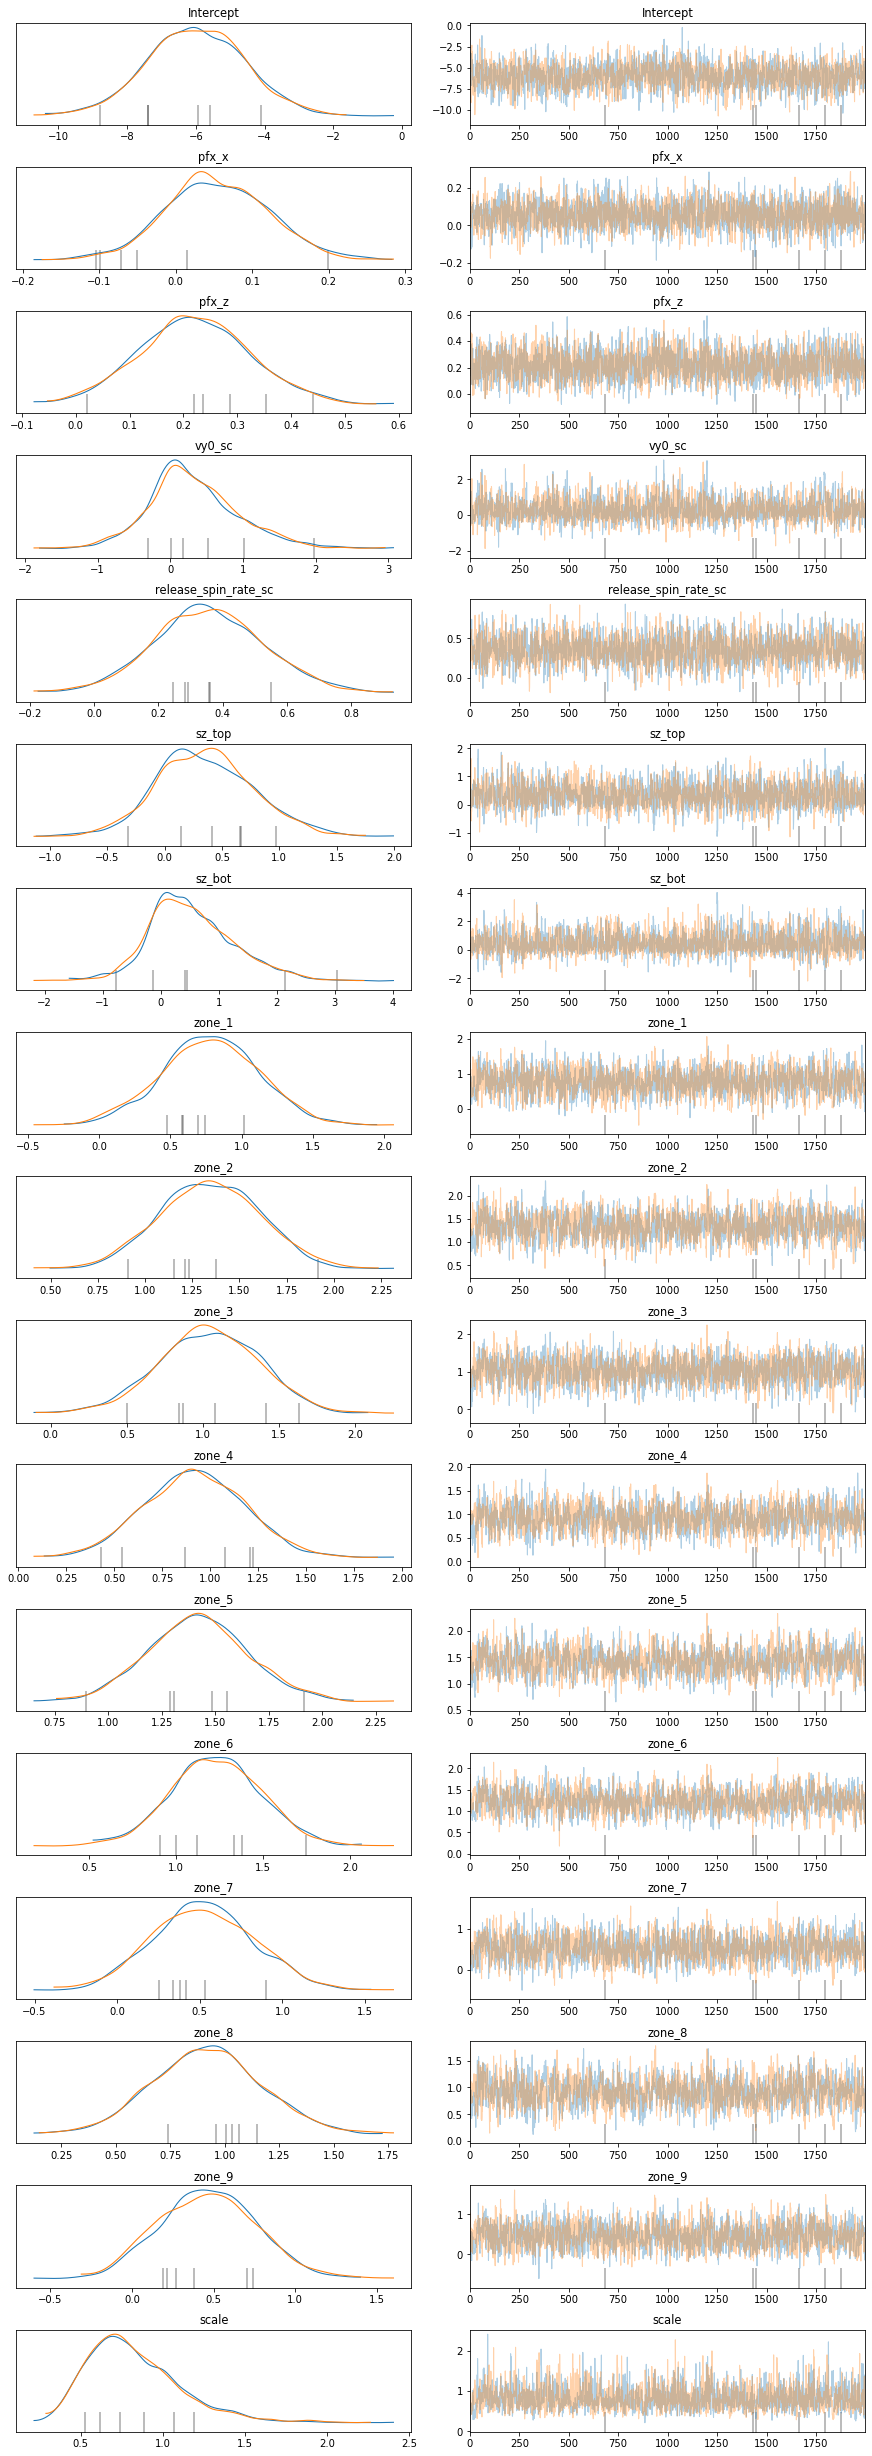

In [36]:
az.plot_trace(trace6)

In [75]:
waic1['p_waic'].round(2)

TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable rint method

In [76]:
print(waic1.round(2).to_latex())
print(waic2.round(2).to_latex())
print(waic3.round(2).to_latex())
print(waic4.round(2).to_latex())
print(trace6_sum.round(2).to_latex())

\begin{tabular}{llllllllll}
\toprule
{} & rank &     waic &   p\_waic &     d\_waic &     weight &       se &      dse & warning & waic\_scale \\
\midrule
contvars     &    0 & -1332.94 &  7.74979 &          0 &   0.484387 &  46.2737 &        0 &   False &        log \\
pitchdummies &    1 & -1333.03 &  7.61333 &  0.0848687 &   0.493906 &  46.3095 &  3.59371 &   False &        log \\
base         &    2 & -1337.41 &  4.29832 &    4.46173 &  0.0217073 &  46.0403 &  2.69666 &   False &        log \\
\bottomrule
\end{tabular}

\begin{tabular}{llllllllll}
\toprule
{} & rank &     waic &   p\_waic &    d\_waic &       weight &       se &      dse & warning & waic\_scale \\
\midrule
zone\_topbot &    0 & -1300.14 &  15.2267 &         0 &     0.596566 &  47.2501 &        0 &   False &        log \\
zonedummies &    1 & -1300.81 &  13.7064 &  0.667257 &     0.403434 &  47.2895 &  1.69975 &   False &        log \\
sz\_topbot   &    2 & -1336.75 &  5.14396 &   36.6035 &  9.93225e-10 &  45.8856 &

In [58]:
ppc = az.from_pymc3_predictions(pm.sample_posterior_predictive(trace6, samples=1000, model=model6))

/home/tmartins/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/home/tmartins/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:xlabel='Log'>

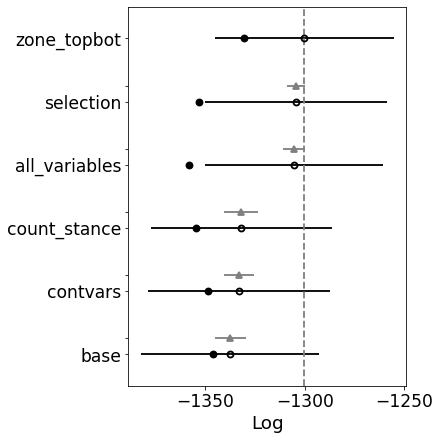

In [64]:
az.plot_compare(waic4)